<a href="https://colab.research.google.com/github/inesbsilveira/hummingbirds/blob/main/Risk_classification/nonpermanence_natural_risks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install geemap
!pip install geojson
!pip install calplot

In [2]:
import os
import csv
import pandas as pd
import geopandas as gpd
from shapely.geometry import Polygon, MultiPolygon, mapping
from shapely.validation import make_valid
import geojson
import ee
import geemap
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import seaborn as sns
import ee
import math
from math import tan
import folium
import statistics
import calplot
import random
from datetime import datetime, timedelta

In [3]:
my_project = 'ee-ineshummingbirds'
ee.Authenticate()
ee.Initialize(project= my_project)

In [17]:
# Define the period of time for temperature and precipitation
start_date = '2024-01-01'
end_date = '2024-12-31'
wf_startDate = '2000-01-01'
wf_endDate = '2024-12-31'
current_year = 2025

In [5]:
# if the input is a shapefile
project_name = 'Uganda'
input_shp = "obr_mount_kei_pro.shp"
#input_shp = "LWS_REDD_Project_Area_Stable_Forest_0324.shp"
gdf = gpd.read_file(input_shp).to_crs('EPSG:4326')
region = geemap.geopandas_to_ee(gdf)

In [6]:
#FUNCTIONS
# Count the number of days with at least one pixel exceeding the threshold
def count_hot_days(image):
    mask = image.reduceRegion(
        reducer=ee.Reducer.anyNonZero(),
        geometry=region,
        scale=1000,
        maxPixels=1e8
    )
    is_above = ee.Algorithms.If(mask.get('temperature_2m'), 1, 0)
    return ee.Feature(None, {'date': image.get('system:time_start'), 'day_above_32': is_above})

def count_flood_events(year):
    start_date = ee.Date.fromYMD(year, 1, 1)
    end_date = ee.Date.fromYMD(year, 12, 31)

    yearly_floods = (gfd.filterDate(start_date, end_date)
                      .select('flooded')
                      .map(lambda img: img.gt(0).And(jrc.Not()))
                      .sum()
                      .gt(0))

    clipped_flood = yearly_floods.clip(region)

    flood_check = clipped_flood.reduceRegion(
        reducer=ee.Reducer.sum(),
        geometry=region.geometry(),
        scale=500,
        maxPixels=1e8
    )

    return ee.Feature(None, {'year': year, 'flood_count': flood_check.get('flooded')})

def get_shapefile_centroid(gdf):
    if gdf.crs is None or gdf.crs.is_projected:
        gdf = gdf.to_crs(epsg=4326)  # Convert to WGS84 (lat/lon)

    #centroid = gdf.unary_union.centroid
    centroid = gdf.geometry.union_all().centroid
    return centroid.y, centroid.x  # (latitude, longitude)

def get_best_crs(latitude, longitude):
    utm_zone = int((180 + longitude) / 6) + 1
    return f"EPSG:{32600 + utm_zone if latitude >= 0 else 32700 + utm_zone}"

# Define slope class ranges
def classify_slope(slope):
    return (slope
            .where(slope.lte(15), 1)   # Flat to very gently sloping (Very low)
            .where(slope.gt(15).And(slope.lte(30)), 2)  # Gently sloping (Low)
            .where(slope.gt(30), 3))  # Steep (Extremely high)

# Compute area per class
def compute_area(class_value, region):
    area = area_per_pixel.updateMask(slope_classified.eq(class_value))
    total_area = area.reduceRegion(
        reducer=ee.Reducer.sum(),
        geometry=region,
        scale=30,
        maxPixels=1e13
    ).getInfo()
    return total_area['area']

# Create a function to process burned area by year
def process_year(n,region):
    # Calculate the start and end date for each year
    ini = startDate.advance(n, 'year')
    end = ini.advance(1, 'year')

    # Filter the burned area collection for the given year
    result = sst.filterDate(ini, end)
    result = result.max().set('system:time_start', ini)

    # Get the burned area (where BurnDate is not 0) and mask it
    result = ee.Image.pixelArea() \
               .divide(10000) \
               .updateMask(result.neq(0))  # Mask out non-burned areas

    # Sum the area of burned forest for the year
    result = result.reduceRegion(
        reducer=ee.Reducer.sum(),
        geometry=region,
        scale=500,
        maxPixels=1e12,
        tileScale=4
    )

    # Extract the area burned in the forest for that year
    burnedArea = result.get('area')

    # Return the area burned in the forest for that year
    return ee.Feature(None, {'burned_area_ha': burnedArea})

# Process burned area per year
def process_year1(n):
    ini = startDate.advance(n, 'year')
    end = ini.advance(1, 'year')

    result = sst.filterDate(ini, end).max()

    # Ensure burned areas are correctly masked
    result = result.updateMask(result.gt(0))  # Keep only burned pixels

    # Compute burned area in hectares
    burned_area = ee.Image.pixelArea() \
                    .divide(10000) \
                    .updateMask(result) \
                    .reduceRegion(
                        reducer=ee.Reducer.sum(),
                        geometry=region,
                        scale=500,
                        maxPixels=1e12
                    )

    return ee.Feature(None, {
        'year': ini.get('year'),  # Ensure year is stored correctly
        'burned_area_ha': burned_area.get('area')
    })

class color:
   PURPLE = '\033[95m'
   CYAN = '\033[96m'
   DARKCYAN = '\033[36m'
   BLUE = '\033[94m'
   GREEN = '\033[92m'
   YELLOW = '\033[93m'
   RED = '\033[91m'
   BOLD = '\033[1m'
   UNDERLINE = '\033[4m'
   END = '\033[0m'

# Classify risk based on the average yearly extreme heat days
def classify_risk(total_days):
    if total_days < 30:
        return 'Low risk'
    elif total_days <= 90:
        return 'Medium risk'
    else:
        return 'High risk'

# Function to remove duplicates based on the date within each collection
def remove_duplicates(collection):
    return collection.map(lambda image: image.set('date', ee.Date(image.get('system:time_start')).format('YYYY-MM-dd'))).distinct('date')

# Apply threshold to the averaged collection
def apply_threshold(image):
    thresholdImage = image.gt(thresholdK)  # Identify pixels above 32°C
    return thresholdImage.set('system:time_start', image.get('system:time_start'))


# Count the number of days where at least one pixel exceeded the threshold
def count_days_above_35(image):
    mask = image.reduceRegion(
        reducer=ee.Reducer.anyNonZero(),
        geometry=region,
        scale=5000,
        bestEffort=True
    )

    isAbove = ee.Algorithms.If(mask.get('tasmax'), 1, 0)

    return ee.Feature(None, {'date': image.get('system:time_start'), 'day_above_32': isAbove})

# Function to compute the average image at a given index
def mean_image_list(collections, indices):
    def compute_mean(i):
        images = [ee.Image(collection.get(i)) for collection in collections]
        mean_img = ee.ImageCollection(images).mean()
        return mean_img.set('system:time_start', images[0].get('system:time_start'))

    return indices.map(compute_mean)

# Function to filter images by season
def filter_by_season(image_collection, start_month, end_month):
    return image_collection.filter(ee.Filter.calendarRange(start_month, end_month, 'month'))

# Extract the month and year from the date to group by month
def add_month_year(image):
    date = ee.Date(image.get('system:time_start'))
    month = date.get('month')
    year = date.get('year')
    return image.set('month', month).set('year', year)

# Group by month and calculate the mean for both temperature and precipitation
def calculate_monthly_means(month):
    # Filter the datasets by the current month
    tempData = tempWithMonth.filter(ee.Filter.eq('month', month))
    precipData = precipWithMonth.filter(ee.Filter.eq('month', month))

    # Calculate the mean temperature for that month across all years
    tempMean = tempData.mean().reduceRegion(
        reducer=ee.Reducer.mean(),
        geometry=region,
        scale=10000,  # Adjust based on your area of interest
        maxPixels=1e8
    )

    # Calculate the mean precipitation for that month across all years
    precipMean = precipData.mean().reduceRegion(
        reducer=ee.Reducer.mean(),
        geometry=region,
        scale=10000,  # Adjust based on your area of interest
        maxPixels=1e8
    )

    # Convert temperature from Kelvin to Celsius (subtract 273.15)
    temperatureCelsius = ee.Number(tempMean.get('temperature_2m')).subtract(273.15)

    # Convert precipitation from meters to millimeters (multiply by 1000)
    precipitationMillimeters = ee.Number(precipMean.get('total_precipitation_sum')).multiply(1000)

    # Create a feature with the month, temperature in Celsius, and precipitation in millimeters
    return ee.Feature(None, {
        'month': month,
        'mean_temperature_celsius': temperatureCelsius,
        'mean_precipitation_mm': precipitationMillimeters
    })

In [7]:
#DEM
dem_dataset = ee.Image('USGS/SRTMGL1_003').clip(region)

#DEM
dem_dataset = ee.Image('USGS/SRTMGL1_003').clip(region)
elevation = dem_dataset.select('elevation')
#Elevation
#calculate mean, min and max elevation value
elevation_stats = elevation.reduceRegion(
    reducer=ee.Reducer.min().combine(ee.Reducer.max(), None, True).combine(ee.Reducer.mean(), None, True),
    geometry=region.geometry(),
    scale=30,
    bestEffort=True
)

elevation_min_value = elevation_stats.get('elevation_min').getInfo()
elevation_max_value = elevation_stats.get('elevation_max').getInfo()
elevation_mean_value = elevation_stats.get('elevation_mean').getInfo()

#Slope
#calculate the slope
slope = ee.Terrain.slope(elevation).clip(region)

slope_stats = slope.reduceRegion(
    reducer=ee.Reducer.min().combine(ee.Reducer.max(), None, True).combine(ee.Reducer.mean(), None, True).combine(ee.Reducer.mode(), None, True),
    geometry=region,
    scale=30,  # change resolution if needed
    maxPixels=1e13
)

slope_min = slope_stats.get('slope_min').getInfo()
slope_max = slope_stats.get('slope_max').getInfo()
slope_mean = slope_stats.get('slope_mean').getInfo()
slope_mode = slope_stats.get('slope_mode').getInfo()

#convert from degrees to percentage
slope_min_percentage = math.tan(math.radians(slope_min)) * 100
slope_max_percentage = math.tan(math.radians(slope_max)) * 100
slope_mean_percentage = math.tan(math.radians(slope_mean)) * 100
slope_mode_percentage = math.tan(math.radians(slope_mode)) * 100

# Classify the risk of erosion based on degrees
if slope_mode_percentage < 15:
  risk_level_erosion = "Low risk"
elif slope_mode_percentage <= 30:
  risk_level_erosion = "Medium risk"
else:
  risk_level_erosion = "High risk"

print(color.BOLD + 'ELEVATION AND SLOPE' + color.END)
print(f'Mean elevation: {elevation_mean_value:.0f} m')
print(f'Minimum elevation: {elevation_min_value:.0f} m')
print(f'Maximum elevation: {elevation_max_value:.0f} m')
print(f'Most common slope value: {slope_mode:.2f}°')
print(f'Mean slope: {slope_mean:.2f}°')
print(f'Minimum slope: {slope_min:.2f}°')
print(f'Maximum slope: {slope_max:.2f}°')
print(color.PURPLE + f"Erosion Risk Level: {risk_level_erosion}" + color.END)

# Apply classification
slope_classified = classify_slope(slope)

# Convert to area (hectares)
area_per_pixel = ee.Image.pixelArea().divide(10000)  # Convert to hectares

# Create table data
classes = [
    (1, "0-15", "Flat to very gently", "Low"),
    (2, "15-30", "Gently slope", "Medium"),
    (3, ">30", "Sloping", "High")
]

# Compute areas
data = []
total_land = sum([compute_area(c[0], region) for c in classes])  # Total land area

for c in classes:
    area_ha = compute_area(c[0], region)
    percentage = (area_ha / total_land) * 100 if total_land else 0
    data.append([c[0], c[1], c[2], c[3], f"{area_ha:,.2f}", f"{percentage:.1f}%"])

# Create DataFrame
df = pd.DataFrame(data, columns=["No", "Classes (°)", "Characteristics", "Susceptibility", "Area (ha)", "Area (%)"])

# Display the table
print(df)

ELEVATION AND SLOPE
Mean elevation: 952 m
Minimum elevation: 825 m
Maximum elevation: 1327 m
Most common slope value: 2.88°
Mean slope: 3.05°
Minimum slope: 0.00°
Maximum slope: 45.41°
Erosion Risk Level: Low risk
   No Classes (°)      Characteristics Susceptibility  Area (ha) Area (%)
0   1        0-15  Flat to very gently            Low  41,183.59    99.5%
1   2       15-30         Gently slope         Medium     184.97     0.4%
2   3         >30              Sloping           High      10.26     0.0%


In [ ]:
# Define visualization parameters for a green-yellow-green color scheme
vis_params = {
    'min': elevation_min_value,
    'max': elevation_max_value,
    'palette': ['green', 'yellow', 'red']  # Green for low, yellow for mid, green for high
}

# Create a map centered on the shapefile region
Map = geemap.Map()
Map.addLayer(elevation, vis_params, "Elevation Map")
fc = region.style(fillColor='00000000')
Map.addLayer(fc, {}, "Transparent Vector")
Map.centerObject(region, 11)
# Add a continuous color gradient legend
Map.add_colorbar(
    vis_params=vis_params,
    label="Elevation (m)",
    orientation="horizontal"
)
# Display the map
Map

In [ ]:
# Save tif to Google Drive
geemap.ee_export_image_to_drive(
    elevation, description=f'elevation_{project_name}', region=region.geometry(), scale=30
)

In [8]:
#temperature - ERA5-Land dataset (temperature in Kelvin)
temp_dataset = (ee.ImageCollection('ECMWF/ERA5_LAND/HOURLY')
                .filterDate(start_date, end_date)
                .select('temperature_2m'))

# Calculate the mean, min, and max annual temperature
mean_temp = temp_dataset.mean().clip(region)
min_temp = temp_dataset.min().clip(region)
max_temp = temp_dataset.max().clip(region)

# Convert temperature from Kelvin to Celsius
mean_temp_celsius = mean_temp.subtract(273.15)
min_temp_celsius = min_temp.subtract(273.15)
max_temp_celsius = max_temp.subtract(273.15)

# Calculate the average, min, and max temperature over the region
temp_stats = mean_temp_celsius.reduceRegion(
    reducer=ee.Reducer.mean(),
    geometry=region.geometry(),
    scale=1000,
    bestEffort=True
)

min_stats = min_temp_celsius.reduceRegion(
    reducer=ee.Reducer.min(),
    geometry=region.geometry(),
    scale=1000,
    bestEffort=True
)

max_stats = max_temp_celsius.reduceRegion(
    reducer=ee.Reducer.max(),
    geometry=region.geometry(),
    scale=1000,
    bestEffort=True
)

# Extract and print temperature values
avg_temp = temp_stats.get('temperature_2m').getInfo()
min_temp_value = min_stats.get('temperature_2m').getInfo()
max_temp_value = max_stats.get('temperature_2m').getInfo()

print(color.BOLD + 'TEMPERATURE 2024' + color.END)
print(f'Average Annual Temperature (°C): {avg_temp:.2f}')
print(f'Minimum Annual Temperature (°C): {min_temp_value:.2f}')
print(f'Maximum Annual Temperature (°C): {max_temp_value:.2f}')


TEMPERATURE 2024
Average Annual Temperature (°C): 25.52
Minimum Annual Temperature (°C): 16.93
Maximum Annual Temperature (°C): 38.33


In [ ]:

# Define the dataset (ERA5-Land hourly temperature data)
dataset = ee.ImageCollection('ECMWF/ERA5_LAND/HOURLY') \
                .filterDate('2024-01-01', '2024-12-31')

# Select the temperature variable (temperature_2m) and convert from Kelvin to Celsius
temperature = dataset.select('temperature_2m').map(lambda img: img.subtract(273.15))

# Calculate the mean temperature over the time period
temperature_mean = temperature.mean()

# Clip the temperature data to the region of interest
temperature_clipped = temperature_mean.clip(region)

# Calculate the min and max temperature values over the region
min_temp = temperature_mean.reduceRegion(
    reducer=ee.Reducer.min(),
    geometry=region,  # Provide the region for aggregation
    scale=1000,       # You can adjust the scale (in meters) based on your dataset resolution
    maxPixels=1e8     # Limit on the number of pixels to be processed
).getInfo()

max_temp = temperature_mean.reduceRegion(
    reducer=ee.Reducer.max(),
    geometry=region,  # Provide the region for aggregation
    scale=1000,       # Same scale as above
    maxPixels=1e8     # Same pixel limit
).getInfo()

# Set the visualization parameters based on min and max temperatures
visualization = {
    'min': min_temp['temperature_2m'],
    'max': max_temp['temperature_2m'],
    'palette': ['#ffffb2', '#fecc5c', '#fd8d3c', '#e31a1c']
}

# Create a folium map centered around the region

# Add the temperature layer to the map
Map = geemap.Map()
Map.addLayer(temperature_clipped, visualization, "Temperature Map")
fc = region.style(fillColor='00000000')
Map.addLayer(fc, {}, "Transparent Vector")
Map.centerObject(region, 11)
# Display the map
Map


In [ ]:
# Save tif to Google Drive
geemap.ee_export_image_to_drive(
    temperature_clipped, description='average_temp_calao_map', region=region.geometry(), scale=30
)

In [7]:
# 2024
# Load the ERA5-Land Daily Aggregated dataset
temp_dataset = ee.ImageCollection('ECMWF/ERA5_LAND/DAILY_AGGR') \
    .filterBounds(region) \
    .filterDate(start_date, end_date) \
    .select('temperature_2m_max')  # Select daily max temperature

# Define the temperature threshold (35°C in Kelvin)
temp_threshold = ee.Number(35).add(273.15)

# Count the number of days exceeding 35°C
hot_days = temp_dataset.map(lambda image: image.gt(temp_threshold).set('date', image.date())).sum()

# Reduce the count over the region (AOI)
hot_days_count_24 = hot_days.reduceRegion(
    reducer=ee.Reducer.mean(),
    geometry=region,
    scale=1000,
    maxPixels=1e9
)


# 2050
models = ['GFDL-ESM4', 'IPSL-CM6A-LR', 'MPI-ESM1-2-HR', 'MRI-ESM2-0', 'UKESM1-0-LL']
hot_days_list = []

for model in models:
  temp_dataset = ee.ImageCollection('NASA/GDDP-CMIP6') \
      .filter(ee.Filter.date('2050-01-01', '2050-12-31')) \
      .filter(ee.Filter.eq('model', model)) \
      .select('tasmax')

  # Define the temperature threshold (35°C in Kelvin)
  temp_threshold = ee.Number(35).add(273.15)

  # Count the number of days exceeding 35°C
  hot_days = temp_dataset.map(lambda image: image.gt(temp_threshold).set('date', image.date())).sum()

  # Reduce the count over the region (AOI)
  hot_days_count = hot_days.reduceRegion(
      reducer=ee.Reducer.mean(),
      geometry=region,
      scale=1000,
      maxPixels=1e9
  )
  hot_days_list.append(hot_days_count.get('tasmax').getInfo())
  # Print the result for 2024
  #print('Number of days above 35C:', hot_days_count.get('tasmax').getInfo())

average = statistics.mean(hot_days_list)

# Classify risk
if average < 30:
    risk_level = "Low risk"
elif average > 90:
    risk_level = "High risk"
else:
    risk_level = "Medium risk"

print(color.BOLD + 'THERMAL STRESS 2050' + color.END)
print('Number of days with temperatures above 35C in 2024:', int(hot_days_count_24.get('temperature_2m_max').getInfo()))
print('Number of days with temperatures above 35C in 2050:', f'{average:.0f}')
print(color.PURPLE + f"Thermal Stress Risk Level: {risk_level}" + color.END)


THERMAL STRESS 2050
Number of days with temperatures above 35C in 2024: 21
Number of days with temperatures above 35C in 2050: 165
Thermal Stress Risk Level: High risk


<ipython-input-8-46ac7608588b>:15: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  data[day] = 1  # 1 represents a hot day


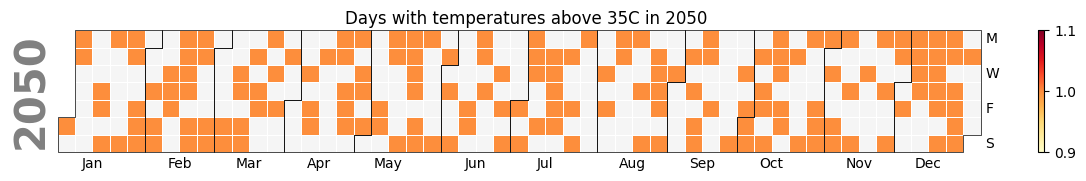

In [8]:
# Set random seed for reproducibility
random.seed(42)

# Create a synthetic dataset for 2050 with approximately 165 hot days
start_date = '2050-01-01'
end_date = '2050-12-31'

# Generate all dates in 2050
dates = pd.date_range(start_date, end_date)
data = pd.Series(0, index=dates)

# Randomly select 165 days to be hot days (temperature > 35°C)
hot_days = random.sample(range(len(data)), 165)
for day in hot_days:
    data[day] = 1  # 1 represents a hot day

# Create the calendar heatmap
calplot.calplot(
    data,
    cmap='YlOrRd',
    edgecolor='black',
    linewidth=0.5,
    daylabels='MTWTFSS',
    dayticks=[0, 2, 4, 6],
    fillcolor='whitesmoke',
    suptitle='Days with temperatures above 35C in 2050',
    #textformat='{:.0f}'
)

plt.show()

In [ ]:
# Load CHIRPS Daily precipitation data
precip_dataset = (ee.ImageCollection('UCSB-CHG/CHIRPS/PENTAD')
          .filterDate(start_date, end_date))

# Sum precipitation over the selected period
total = precip_dataset.reduce(ee.Reducer.sum())

# Compute mean precipitation within the given region
stats = total.reduceRegion(
    reducer=ee.Reducer.mean(),
    geometry=region,
    scale=5000
)

# Define the dry and wet seasons
dry_season_1stmonth = 12
dry_season_lastmonth = 2
wet_season_1stmonth = 3
wet_season_lastmonth = 11

# Filter the dataset for each season
dry_season = filter_by_season(precip_dataset, dry_season_1stmonth, dry_season_lastmonth).filterDate(start_date, end_date)
wet_season = filter_by_season(precip_dataset, wet_season_1stmonth, wet_season_lastmonth).filterDate(start_date, end_date)

# Compute total precipitation sum for dry season
total_dry = dry_season.reduce(ee.Reducer.sum()).reduceRegion(
    reducer=ee.Reducer.mean(),
    geometry=region,
    scale=5000
)

# Compute total precipitation sum for wet season
total_wet = wet_season.reduce(ee.Reducer.sum()).reduceRegion(
    reducer=ee.Reducer.mean(),
    geometry=region,
    scale=5000
)

# Extract the precipitation sum values
dry_precip_value = total_dry.getInfo().get('precipitation_sum')
wet_precip_value = total_wet.getInfo().get('precipitation_sum')

print(color.BOLD + 'PRECIPITATION 2024' + color.END)
print(f"Total Precipitation: {stats.getInfo().get('precipitation_sum'):.2f} mm")
print(f"Total Dry Season Precipitation: {dry_precip_value:.2f} mm")
print(f"Total Wet Season Precipitation: {wet_precip_value:.2f} mm")

# Define the time range
start_year_prec = 1994
end_year_prec = 2024

# Load CHIRPS precipitation data
chirps = ee.ImageCollection('UCSB-CHG/CHIRPS/PENTAD')

# Initialize a list to store the precipitation values for each year
annual_precipitation = []

# Loop through each year in the range
for year in range(start_year_prec, end_year_prec + 1):
    # Filter CHIRPS data for the specific year
    chirps_year = chirps.filter(ee.Filter.calendarRange(year, year, 'year'))

    # Sum precipitation over the selected year
    total_year = chirps_year.reduce(ee.Reducer.sum())

    # Compute mean precipitation for the year within the given region
    stats_year = total_year.reduceRegion(
        reducer=ee.Reducer.mean(),
        geometry=region,
        scale=5000
    )

    # Extract the total precipitation for the year
    yearly_precip = stats_year.get('precipitation_sum')

    # Append the result to the list
    annual_precipitation.append((year, yearly_precip.getInfo()))

# Print out the results
#for year, precip in annual_precipitation:
    #print(f"Year {year}: Total Precipitation = {precip:.2f} mm")

# Extract years and precipitation values for plotting
years = [year for year, _ in annual_precipitation]
precipitation = [precip for _, precip in annual_precipitation]

# Calculate mean annual precipitation
mean_precipitation = np.mean(precipitation)

# Print the result
print(f"Mean Annual Precipitation (1994-2024): {mean_precipitation:.2f} mm")

# Plot the data
plt.figure(figsize=(10, 6))
plt.scatter(years, precipitation, color ='#4b8292')
plt.title('Annual Total Precipitation (1994 - 2024)')
plt.xlabel('Year')
plt.ylabel('Total Precipitation (mm)')
z = np.polyfit(years, precipitation, 1)
p = np.poly1d(z)
plt.plot(years, p(years), "r--", label="Trend Line", color='#E77577')
plt.grid(True)
plt.xticks(years, rotation=45)
plt.ylim(0, max(precipitation) * 1.1)
plt.grid(False)
plt.tight_layout()
plt.show()

In [ ]:
# Define the dataset (ERA5-Land hourly temperature data)
dataset = ee.ImageCollection('UCSB-CHG/CHIRPS/PENTAD') \
                .filterDate('2024-01-01', '2024-12-31')

# Sum precipitation over the selected period
total = dataset.reduce(ee.Reducer.sum())

# Clip the temperature data to the region of interest
precipitation = total.clip(region)

# Calculate the min and max temperature values over the region
min_precip = total.reduceRegion(
    reducer=ee.Reducer.min(),
    geometry=region,  # Provide the region for aggregation
    scale=1000,       # You can adjust the scale (in meters) based on your dataset resolution
    maxPixels=1e8     # Limit on the number of pixels to be processed
).getInfo()

max_precip = total.reduceRegion(
    reducer=ee.Reducer.max(),
    geometry=region,  # Provide the region for aggregation
    scale=1000,       # Same scale as above
    maxPixels=1e8     # Same pixel limit
).getInfo()

# Set the visualization parameters based on min and max temperatures
visualization = {
    'min': min_precip['precipitation_sum'],
    'max': max_precip['precipitation_sum'],
    'palette': ['fff7fb', 'ece2f0', 'd0d1e6', 'a6bddb', '67a9cf', '1c9099', '016c59', '014636']

}

# Create a folium map centered around the region

# Add the temperature layer to the map
Map = geemap.Map()
Map.addLayer(precipitation, visualization, "Precipitation Map")
fc = region.style(fillColor='00000000')
Map.addLayer(fc, {}, "Transparent Vector")
Map.centerObject(region, 11)
# Display the map
Map

In [ ]:
# Save tif to Google Drive
geemap.ee_export_image_to_drive(
    precipitation, description='total_precipitation_calao_map', region=region.geometry(), scale=30
)

In [ ]:
# Load the ERA5 Monthly dataset for temperature and precipitation
tempDataset = ee.ImageCollection("ECMWF/ERA5_LAND/MONTHLY_AGGR") \
                .filterDate('1994-01-01', '2024-12-31') \
                .select('temperature_2m')  # Temperature dataset

precipDataset = ee.ImageCollection("ECMWF/ERA5_LAND/MONTHLY_AGGR") \
                .filterDate('1994-01-01', '2024-12-31') \
                .select('total_precipitation_sum')  # Precipitation dataset

tempWithMonth = tempDataset.map(add_month_year)
precipWithMonth = precipDataset.map(add_month_year)

# Create a list of months (1 to 12) and calculate the monthly means
monthlyMeans = ee.List.sequence(1, 12).map(calculate_monthly_means)

# Convert the list of features to a FeatureCollection
monthlyMeansFC = ee.FeatureCollection(monthlyMeans)

# Print the result to check
#print(monthlyMeansFC.getInfo())

# Create the combo chart (Bar + Line)
# Extract the monthly data from the FeatureCollection
features = monthlyMeansFC.getInfo()['features']
months = [feature['properties']['month'] for feature in features]
temperatures = [feature['properties']['mean_temperature_celsius'] for feature in features]
precipitation = [feature['properties']['mean_precipitation_mm'] for feature in features]

# Plot the data
fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot precipitation as bars
ax1.bar(months, precipitation, color='#4b8292', width=0.4, label='Precipitation (mm)', align='center')
ax1.set_xlabel('Month')
ax1.set_ylabel('Precipitation (mm)', color='#4b8292')
ax1.tick_params(axis='y', labelcolor='#4b8292')

# Set the y-axis limit for precipitation (0 to 200 mm)
ax1.set_ylim(0, 350)

# Create a second y-axis for the temperature
ax2 = ax1.twinx()
ax2.plot(months, temperatures, color='#E77577', label='Temperature (°C)', marker='o', linestyle='-', linewidth=2)
ax2.set_ylabel('Temperature (°C)', color='#E77577')
ax2.tick_params(axis='y', labelcolor='#E77577')

# Set the y-axis limit for temperature (0 to 30°C)
ax2.set_ylim(0, 30)

# Set chart title
plt.title('Average Monthly Precipitation and Temperature (1994-2024)')

# Show the plot
plt.tight_layout()
plt.show()


In [ ]:
#floods -  MODIS Global Flood Database (GFD) and JRC permanent water mask
gfd = ee.ImageCollection('GLOBAL_FLOOD_DB/MODIS_EVENTS/V1')
jrc = (ee.ImageCollection('JRC/GSW1_4/YearlyHistory')
       .select('waterClass')
       .map(lambda img: img.eq(3))  # Permanent water class
       .max())

# Define years for flood analysis
years = ee.List.sequence(2000, 2018)

# Convert flood counts to FeatureCollection
flood_counts_fc = ee.FeatureCollection(years.map(count_flood_events))

total_floods = flood_counts_fc.aggregate_sum('flood_count').getInfo()

# Classify risk
if total_floods == 0:
    risk_level = "Low risk"
elif total_floods == 1:
    risk_level = "Medium risk"
else:
    risk_level = "High risk"

print(color.BOLD + 'FLOODS 2000-2018' + color.END)
if total_floods > 0:
    print('Floods detected in the project area')
else:
    print('No floods detected in the project area')
print('Number of total flood events:', total_floods)
#print(f'Flood Risk Level: {risk_level}')
print(color.PURPLE + f"Flood Risk Level: {risk_level}" + color.END)

In [20]:
#drought - SPEI dataset
spei_dataset = ee.ImageCollection("CSIC/SPEI/2_10") \
    .filterBounds(region) \
    .filterDate("1992-01-01", "2022-01-01")

# Compute average SPEI indices
spei_avg = spei_dataset.reduce(ee.Reducer.mean()).clip(region).select([
    "SPEI_03_month_mean", "SPEI_06_month_mean", "SPEI_09_month_mean", "SPEI_12_month_mean"
])

spei_avg_dict = spei_avg.reduceRegion(
    reducer=ee.Reducer.mean(),
    geometry=region,
    scale=55660,
    maxPixels=1e9
)

# get the results as a dictionary so we can convert them into a df
spei_avg_values = spei_avg_dict.getInfo()
# convert to a df
df = pd.DataFrame([spei_avg_values])

# rename columns
df.rename(columns={
    'SPEI_03_month_mean': 'SPEI_03',
    'SPEI_06_month_mean': 'SPEI_06',
    'SPEI_09_month_mean': 'SPEI_09',
    'SPEI_12_month_mean': 'SPEI_12'
}, inplace=True)

print(df)

# Add a binary drought flag to each image
def add_drought_flag(image):
    spei = image.select("SPEI_09_month")
    drought_flag = spei.lt(-1.5).rename("drought_flag")
    return image.addBands(drought_flag)

# Map the function over the dataset
drought_flagged = spei_dataset.map(add_drought_flag)

# Reduce over time: sum of drought flags and count of total images
drought_stats = drought_flagged.select("drought_flag").reduce(ee.Reducer.sum().combine(
    reducer2=ee.Reducer.count(), sharedInputs=True
))

# Reduce over region to get scalar values
stats = drought_stats.reduceRegion(
    reducer=ee.Reducer.mean(),
    geometry=region,
    scale=55660,
    maxPixels=1e9
)

# Extract the drought stats
num_drought_events = ee.Number(stats.get("drought_flag_sum"))
total_features = ee.Number(stats.get("drought_flag_count"))

# Compute drought percentage
percentage_drought = num_drought_events.divide(total_features).multiply(100)

# Fetch final results safely
pct = percentage_drought.getInfo()


    SPEI_03   SPEI_06   SPEI_09   SPEI_12
0 -0.120517 -0.118233 -0.110564 -0.106283
DROUGHT 1992-2022
Months with severe drought: 2.50 %


9


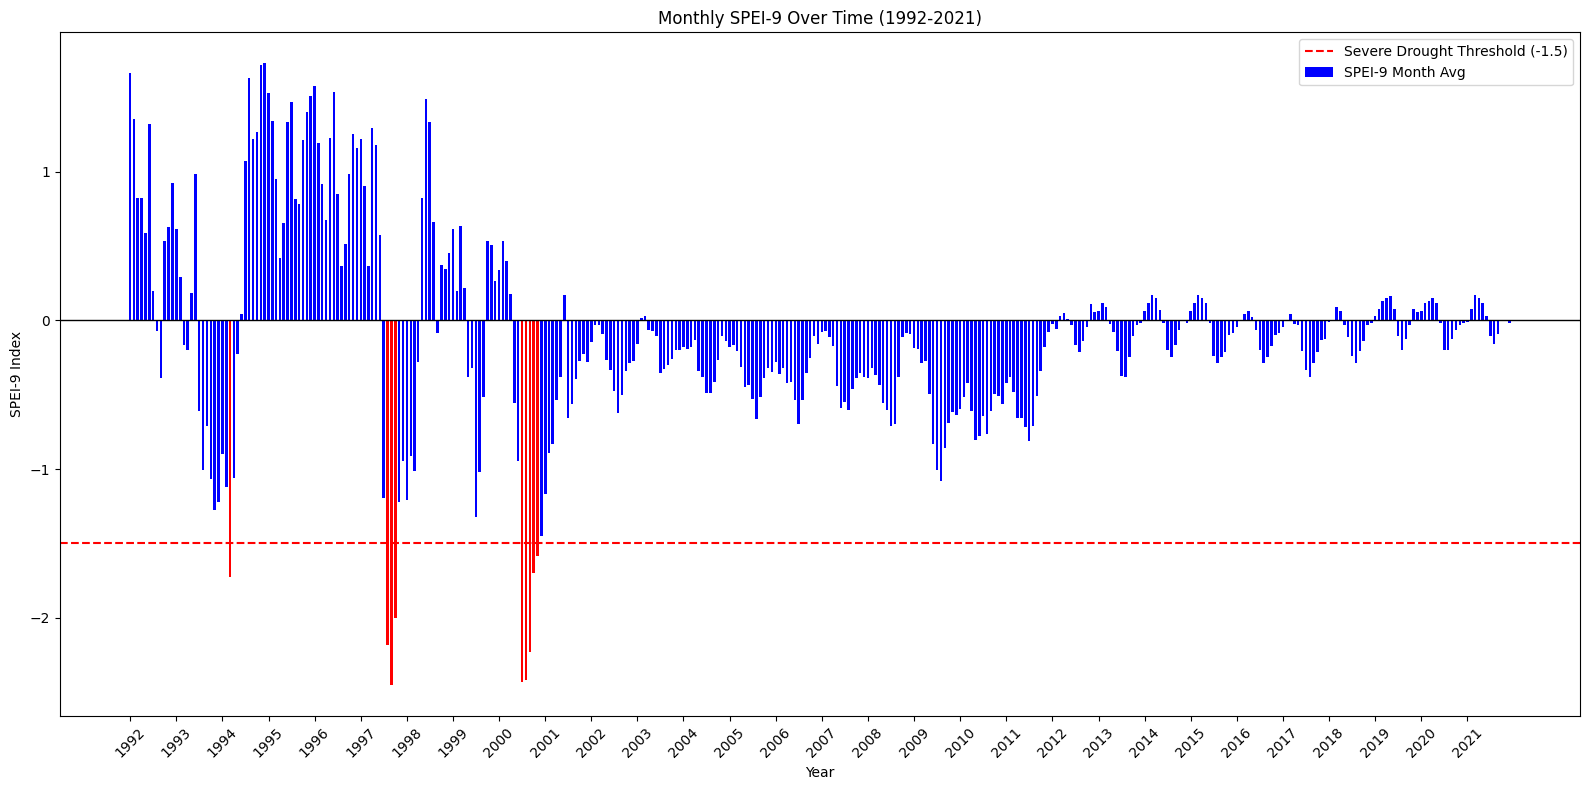

In [21]:
if df["SPEI_09"].isnull().all():
  buffered_region = region.geometry().buffer(10000)
  # Compute drought risk based on SPEI-9
  chart_data = spei_dataset.map(lambda image:
      ee.Feature(None, {
          "Date": image.get("system:time_start"),
          "SPEI_09_month": image.select("SPEI_09_month").reduceRegion(
              reducer=ee.Reducer.mean(),
              geometry=buffered_region,
              scale=55660,
              maxPixels=1e9
          ).get("SPEI_09_month")
      })
  )
else:
  chart_data = spei_dataset.map(lambda image:
      ee.Feature(None, {
          "Date": image.get("system:time_start"),
          "SPEI_09_month": image.select("SPEI_09_month").reduceRegion(
              reducer=ee.Reducer.mean(),
              geometry=region.geometry(),
              scale=55660,
              maxPixels=1e9
          ).get("SPEI_09_month")
      })
  )


# Convert to FeatureCollection
chart_list = chart_data.toList(chart_data.size())
# Convert chart_data to a list
chart_list = chart_data.aggregate_array("Date").getInfo()
spei_values = chart_data.aggregate_array("SPEI_09_month").getInfo()

# Convert dates from milliseconds to datetime format
dates = pd.to_datetime(chart_list, unit='ms')

# Create DataFrame
df = pd.DataFrame({"Date": dates, "SPEI_09_month": spei_values})
# Ensure 'Date' is in datetime format
df['Date'] = pd.to_datetime(df['Date'])
count_drought = (df['SPEI_09_month'] < -1.5).sum()
print(count_drought)

# Plot SPEI-9 over time with better handling for many bars
plt.figure(figsize=(16, 8))

# Create bars - using narrower width for better visibility
bars = plt.bar(df['Date'], df["SPEI_09_month"],
               width=20,  # Narrower bars to fit 360 of them
               color=np.where(df["SPEI_09_month"] < -1.5, 'red', 'b'),  # Color drought values red
               label="SPEI-9 Month Avg")

threshold = -1.5

# Formatting
plt.axhline(y=0, color='black', linewidth=1)  # Zero line for reference
plt.axhline(y=threshold, color='red', linestyle='--', label='Severe Drought Threshold (-1.5)')
plt.xlabel("Year")
plt.ylabel("SPEI-9 Index")
plt.title("Monthly SPEI-9 Over Time (1992-2021)")
#plt.ylim(-2, 2)

# Improve x-axis ticks to show years only
years = pd.date_range(start=df['Date'].min(), end=df['Date'].max(), freq='YS')
plt.xticks(years, [y.strftime('%Y') for y in years], rotation=45)

plt.legend()
plt.grid(False)

# Adjust layout to prevent label cutoff
plt.tight_layout()

# Show plot
plt.show()

In [22]:

df['Date'] = pd.to_datetime(df['Date'])

# Filter drought months where SPEI_09_month < -1.5
drought_months = df[df['SPEI_09_month'] < -1.5]

# Count drought months
count_drought = len(drought_months)
print(f"Number of drought months: {count_drought}")

# Find the most recent drought month
if not drought_months.empty:
    last_dry_date = drought_months['Date'].max()
    print(f"Last dry month: {last_dry_date.strftime('%Y-%m-%d')}")
else:
    # If no drought months found, handle appropriately
    last_dry_date = None
    print("No drought months found")

if last_dry_date:
    last_dry_year = last_dry_date.year
    print(f"Year of last dry month: {last_dry_year}")
else:
    last_dry_year = None
    print("No year to extract since no drought months found")

last_dry_month = current_year - last_dry_year
print(f"Number of years since last dry month: {last_dry_month}")


Number of drought months: 9
Last dry month: 2000-11-01
Year of last dry month: 2000
Number of years since last dry month: 25


In [23]:
def classify_risk(pct, last_dry_month):
    if pct < 5:
        if last_dry_month < 5:
            return "Medium risk"
        else:
            return "Low risk"
    elif 5 <= pct <= 10:
        if last_dry_month < 5:
            return "High risk"
        else:
            return "Medium risk"
    else:  # pct > 10
        if last_dry_month < 5:
            return "High risk"
        elif 5 <= last_dry_month <= 10:
            return "High risk"
        else:
            return "Medium risk"

risk = classify_risk(pct, last_dry_month)
print(f"Drought percentage: {pct:.2f}%")
print(f"Drought risk level: {risk}")

Drought percentage: 2.50%
Drought risk level: Low risk


In [25]:
# Dry season definition (global)
dry_season_1stmonth = 12
dry_season_lastmonth = 2
wet_season_1stmonth = 3
wet_season_lastmonth = 11

In [24]:
def process_year_dry_season(n, region):
    n = ee.Number(n)
    year = ee.Number(startDate.get('year')).add(n)

    # Define dry season: Dec (year N) to Feb (year N+1)
    season_start = ee.Date.fromYMD(year, dry_season_1stmonth, 1)
    season_end = ee.Date.fromYMD(year.add(1), wet_season_1stmonth, 1)

    # Filter MODIS for dry season
    season_data = sst.filterDate(season_start, season_end)

    # Burned area mask
    burned = season_data.map(lambda image: image.gt(0).selfMask())

    # Sum of all burn occurrences in dry season
    burned_sum = burned.sum().clip(region)

    # Calculate burned area in hectares
    pixel_area_ha = burned_sum.multiply(ee.Image.pixelArea()).divide(10000)

    # Reduce region to get total burned area
    stats = pixel_area_ha.reduceRegion(
        reducer=ee.Reducer.sum(),
        geometry=region.geometry(),
        scale=500,
        maxPixels=1e13
    )

    burned_area_ha = stats.get('BurnDate')
    return ee.Feature(None, {
        'year': year,
        'burned_area_ha': burned_area_ha
    }).set('system:index', year.format('%d'))


EPSG:32636
Total project area: 41532.84 ha
Total project area with 10km buffer: 164902.40 ha
WILDFIRES 2000-2024
Mean burned area: 26.10%
Frequency of big fire years: 100.00%
Freqeuncy of medium fire years: 0.00%
Fire Risk Level: High risk


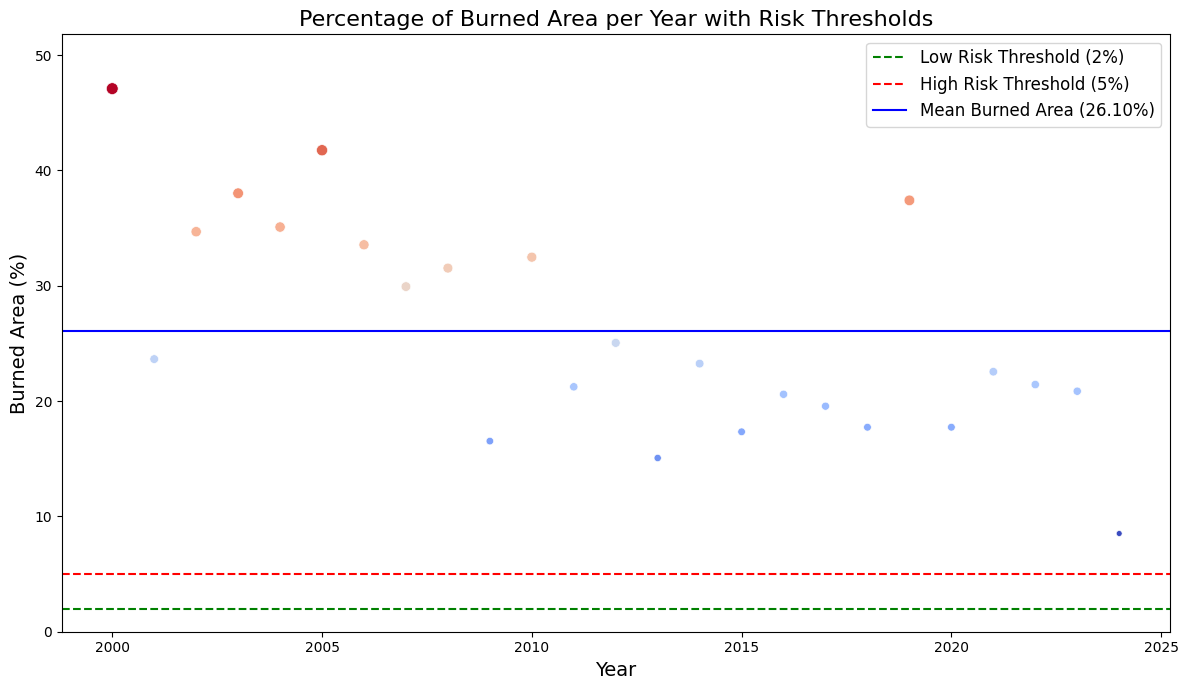

In [28]:
# considering only dry season!!
startDate = ee.Date(wf_startDate)
endDate = ee.Date(wf_endDate)

#retrive lat and long to get the adequate CRS for a correct area calculation
latitude, longitude = get_shapefile_centroid(gdf)
#print(f"Central Point: ({latitude}, {longitude})")
best_epsg = get_best_crs(latitude, longitude)
print(best_epsg)
#calculate total area
gdf_crs = gdf.to_crs(best_epsg)
total_area_ha = (gdf_crs['geometry'].area/10000).sum()

# buffered area
gdf_buffered = gdf_crs.buffer(10000) # 10km buffer
total_area_buffered_ha = (gdf_buffered.area/10000).sum()
gdf_buffered_df = gpd.GeoDataFrame(geometry=gdf_buffered, crs=best_epsg)

#print
print(f'Total project area: {total_area_ha:.2f} ha')
print(f'Total project area with 10km buffer: {total_area_buffered_ha:.2f} ha')

# Convert to an Earth Engine object
region = geemap.geopandas_to_ee(gdf_buffered_df)

# MODIS Burned Area dataset
sst = ee.ImageCollection("MODIS/061/MCD64A1") \
            .select('BurnDate') \
            .filterDate(startDate, endDate)

# calculate number of years to process
nYears = ee.Number(endDate.difference(startDate, 'year')).round().subtract(1)
#print(f'Number of years: {nYears.getInfo()}')

# processs burned area per year
#byYear = ee.FeatureCollection(
#    ee.List.sequence(0, nYears).map(lambda n: process_year(n, region))
#)

byYear = ee.FeatureCollection(
    ee.List.sequence(0, nYears).map(lambda n: process_year_dry_season(n, region))
)

#features from the Earth Engine FeatureCollection
features = byYear.getInfo()['features']

#'area_ha' values and their corresponding years
data = []
for feature in features:
    year = feature['id']
    area_ha = feature['properties']['burned_area_ha']
    data.append({'year': int(year), 'burned_area_ha': area_ha})

#convert to pandas dataframe
df_wf = pd.DataFrame(data)
#print(df_wf)

#add new column to the df with the percentage of burned area per year
df_wf['burned_area_percentage'] = (df_wf['burned_area_ha'] / total_area_buffered_ha) * 100

# Calculate mean and standard deviation for area burned in hectares
mean_area_percentage = df_wf['burned_area_percentage'].mean()
std_area_percentage = df_wf['burned_area_percentage'].std()

# Step 1: Identify big fire years
df_wf['is_big_fire_year'] = df_wf['burned_area_percentage'] > 5 #(mean_area_percentage + std_area_percentage)
df_wf['is_medium_fire_year'] = (df_wf['burned_area_percentage'] > 2) & (df_wf['burned_area_percentage'] <= 5)
# Step 2: Calculate frequency of big fire years
big_fire_frequency = df_wf['is_big_fire_year'].mean() * 100  # Frequency in percentage
medium_fire_frequency = df_wf['is_medium_fire_year'].mean() * 100  # Frequency in percentage
nr_big_fire_years = df_wf['is_big_fire_year'].sum()
nr_medium_fire_years = df_wf['is_medium_fire_year'].sum()

# Step 3: Classify fire risk
if mean_area_percentage < 2:
    if nr_big_fire_years >= 1:
        risk_level_wf = "High risk"
    elif nr_medium_fire_years >= 1:
        risk_level_wf = "Medium risk"
    else:
        risk_level_wf = "Low risk"
elif 2 <= mean_area_percentage <= 5:
    if nr_big_fire_years >= 1:
        risk_level_wf = "High risk"
    elif nr_medium_fire_years >= 1:
        risk_level_wf = "Medium risk"
    else:
        risk_level_wf = "Medium risk"
else:
    risk_level_wf = "High risk"

print(color.BOLD + 'WILDFIRES 2000-2024' + color.END)
print(f"Mean burned area: {mean_area_percentage:.2f}%")
print(f"Frequency of big fire years: {big_fire_frequency:.2f}%")
print(f"Freqeuncy of medium fire years: {medium_fire_frequency:.2f}%")
print(color.PURPLE + f"Fire Risk Level: {risk_level_wf}" + color.END)

# Define risk thresholds
low_risk_threshold = 2  # Low risk threshold (10%)
high_risk_threshold = 5  # High risk threshold (30%)
mean_threshold = mean_area_percentage  # Mean burned area percentage

# Add a column for point size (optional, for visualization purposes)
df_wf['point_size'] = df_wf['burned_area_percentage'] * 10  # Scale size for better visualization

# Create the scatter plot
plt.figure(figsize=(12, 7))
sns.scatterplot(
    data=df_wf,
    x='year',
    y='burned_area_percentage',
    size='point_size',
    hue='burned_area_percentage',
    palette='coolwarm',
    legend=False
)

# Add horizontal lines for risk thresholds
plt.axhline(y=low_risk_threshold, color='green', linestyle='--', label='Low Risk Threshold (2%)')
plt.axhline(y=high_risk_threshold, color='red', linestyle='--', label='High Risk Threshold (5%)')
plt.axhline(y=mean_threshold, color='blue', linestyle='-', label=f'Mean Burned Area ({mean_threshold:.2f}%)')

# Set labels and title
plt.title(f'Percentage of Burned Area per Year with Risk Thresholds', fontsize=16)
plt.xlabel('Year', fontsize=14)
plt.ylabel('Burned Area (%)', fontsize=14)

# Set y-axis limits
plt.ylim(0, df_wf['burned_area_percentage'].max() * 1.1)

# Show legend
plt.legend(loc='upper right', fontsize=12)

# Show the plot
plt.tight_layout()
plt.show()

In [27]:
### Only dry season

# Load MODIS Burned Area dataset and filter by date
burned = (
    ee.ImageCollection("MODIS/061/MCD64A1")
    .select('BurnDate')
    .filterDate(startDate, endDate)
)

# Convert BurnDate values into a binary burn occurrence (1 for burned, 0 otherwise)
burned_binary = burned.map(lambda img: img.gt(0).unmask(0))

# Sum the occurrences of burned areas over time
burn_count = burned_binary.sum().clip(region)
print(burn_count.getInfo())

# Get the statistics of burn_count over the region
burn_stats = burn_count.reduceRegion(
    reducer=ee.Reducer.minMax().combine(
        ee.Reducer.mean(), sharedInputs=True
    ).combine(
        ee.Reducer.stdDev(), sharedInputs=True
    ),
    geometry=region,
    scale=1000,  # MODIS resolution is ~500m
    bestEffort=True
)


burnDate_max = burn_stats.get('BurnDate_max')
burnDate_min = burn_stats.get('BurnDate_min')
#print(burn_stats.getInfo())

gdf = gpd.read_file(input_shp).to_crs('EPSG:4326')
region_o = geemap.geopandas_to_ee(gdf)

# Retrieve the actual min and max values as Python numbers
burnDate_min_val = burnDate_min.getInfo()
burnDate_max_val = burnDate_max.getInfo()

# Define visualization parameters
vis_params = {
    'min': burnDate_min_val,
    'max': burnDate_max_val,
    'palette': ['white', '#FFFFB2', '#FECC5C', '#FD8D3C', '#E31A1C']  # YlOrRd_04 color palette
}
print(f"Min Burn Date: {burnDate_min_val}")
print(f"Max Burn Date: {burnDate_max_val}")
# Create an interactive map
Map = geemap.Map()

# Center the map around your region
Map.centerObject(region, 11)
# Add the burn frequency layer
Map.addLayer(burn_count, vis_params, "Burn Frequency")
fc = region.style(fillColor='00000000')  # Transparent fill for 'region'
Map.addLayer(fc, {}, "Transparent Region Boundary")
#region original
fc_o = region_o.style(fillColor='00000000')  # Transparent fill for 'region_o'
Map.addLayer(fc_o, {}, "Transparent Region O Boundary")
Map.add_colorbar(
    vis_params=vis_params,
    label="Fire Frequency (years)",
    orientation="horizontal"
)
# Display the map
Map

{'type': 'Image', 'bands': [{'id': 'BurnDate', 'data_type': {'type': 'PixelType', 'precision': 'int', 'min': -9.223372036854776e+18, 'max': 9.223372036854776e+18}, 'crs': 'EPSG:4326', 'crs_transform': [1, 0, 0, 0, 1, 0]}]}
Min Burn Date: 0
Max Burn Date: 25


Map(center=[3.6932221364279876, 31.149927656886753], controls=(WidgetControl(options=['position', 'transparent…

In [31]:
# Parse start and end years
start_year = ee.Date(startDate).get('year')
end_year = ee.Date(endDate).get('year')

# Create list of years to process
years = ee.List.sequence(start_year, end_year.subtract(1))  # Exclude last year

# Function to get dry season images for a given year
def get_dry_season_images(year):
    year = ee.Number(year)
    season_start = ee.Date.fromYMD(year, dry_season_1stmonth, 1)
    season_end = ee.Date.fromYMD(year.add(1), wet_season_1stmonth, 1)
    return burned.filterDate(season_start, season_end)

# Combine all dry season images
dry_season_collection = ee.ImageCollection(
    years.map(get_dry_season_images)
         .iterate(lambda col, acc: ee.ImageCollection(acc).merge(ee.ImageCollection(col)), ee.ImageCollection([]))
)

# Convert BurnDate values into binary burn occurrence (1 = burned)
burned_binary = dry_season_collection.map(lambda img: img.gt(0).unmask(0))

# Sum burn occurrences across all dry seasons
burn_count = burned_binary.sum().clip(region)

# Get statistics over the region
burn_stats = burn_count.reduceRegion(
    reducer=ee.Reducer.minMax().combine(
        ee.Reducer.mean(), sharedInputs=True
    ).combine(
        ee.Reducer.stdDev(), sharedInputs=True
    ),
    geometry=region,
    scale=1000,  # MODIS resolution is ~500m
    bestEffort=True
)

# Access values
burnDate_max = burn_stats.get('BurnDate_max')
burnDate_min = burn_stats.get('BurnDate_min')

# Optional: convert to local values
burnDate_max_val = burnDate_max.getInfo()
burnDate_min_val = burnDate_min.getInfo()


In [32]:
# Define visualization parameters
vis_params = {
    'min': burnDate_min_val,
    'max': burnDate_max_val,
    'palette': ['white', '#FFFFB2', '#FECC5C', '#FD8D3C', '#E31A1C']  # YlOrRd_04 color palette
}
print(f"Min Burn Date: {burnDate_min_val}")
print(f"Max Burn Date: {burnDate_max_val}")
# Create an interactive map
Map = geemap.Map()

# Center the map around your region
Map.centerObject(region, 11)
# Add the burn frequency layer
Map.addLayer(burn_count, vis_params, "Burn Frequency")
fc = region.style(fillColor='00000000')  # Transparent fill for 'region'
Map.addLayer(fc, {}, "Transparent Region Boundary")
#region original
fc_o = region_o.style(fillColor='00000000')  # Transparent fill for 'region_o'
Map.addLayer(fc_o, {}, "Transparent Region O Boundary")
Map.add_colorbar(
    vis_params=vis_params,
    label="Fire Frequency (years)",
    orientation="horizontal"
)
# Display the map
Map

Min Burn Date: 0
Max Burn Date: 24


Map(center=[3.6932221364279876, 31.149927656886753], controls=(WidgetControl(options=['position', 'transparent…

In [ ]:
# Save tif to Google Drive
geemap.ee_export_image_to_drive(
    burn_count, description=f'burned_frequency_{project_name}', region=region.geometry(), scale=30
)